<a href="https://colab.research.google.com/github/siqitoday/Playground/blob/main/Advanced_Deep_Learning_IAP_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright Léonard Boussioux and The TensorFlow Authors 

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using **transfer learning** from a **pre-trained convolutional neural network**.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task (e.g., ImageNet). You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. **Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. **Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

We will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model

This notebook is divided in 4 parts:

- Part 1: Data Preprocessing 
- Part 2: Transfer Learning: the Principles
- Part 3: Feature Extraction
- Part 4: Fine-Tuning


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Part 1: Data Preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

This step is critical. GPUs and TPUs can radically reduce the time required to execute a single training step. Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished. The `tf.data` API helps to build flexible and efficient input pipelines.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

#Choose your batch size: typically ranges from 16 to 256, using powers of 2.
BATCH_SIZE = 32

#Choose your image size: the larger, the finer the details on the image 
#but also longer computational time and potential for overfit
#Classic sizes range from 160 to 512. 224 is a typical value. 
#The choice depends also on the architecture you plan to use
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Notice that this dataset is also conveniently available from Google and could be loaded as follows:

```python
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)
```

### Check images

Show the first nine images and labels from the training set:

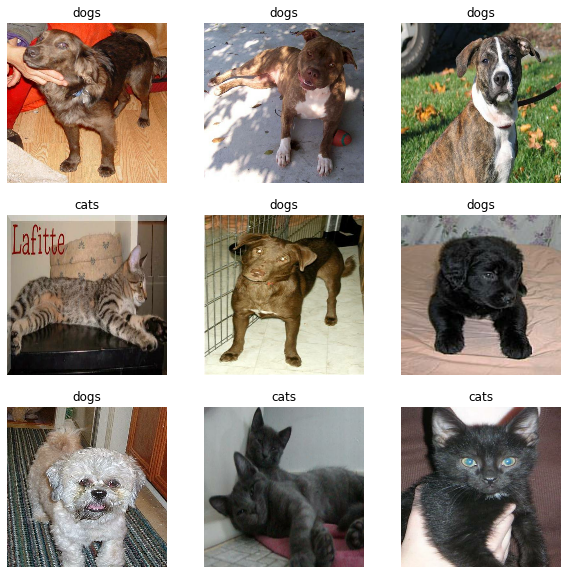

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance (optional)

The following is advanced and pretty recent. I haven't used it personnally yet in my research but is good to know! You can use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).
You have two options to apply the data augmentation:

1. **Option 1: Make the preprocessing layers part of your model.**

There are two important points to be aware of in this case:

- Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
- When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

2. **Option 2: Apply the preprocessing layers to your dataset**

In this case:

- Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing.
- The preprocessing layers will not be exported with the model when you call `Model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.


In this tutorial, we use the first option. The best one depends on your application and personal taste.

There exists many augmentation techniques. The most common are `RandomFlip` and `RandomRotation`.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2, fill_mode = 'reflect'),
  #tf.keras.layers.RandomContrast(factor=(0.5, 0.5)),
  #tf.keras.layers.RandomZoom(height_factor=0.5, width_factor=0.2),
  #tf.keras.layers.GaussianNoise(stddev = 0.2)
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`.

Let's repeatedly apply these layers to the same image and see the result.

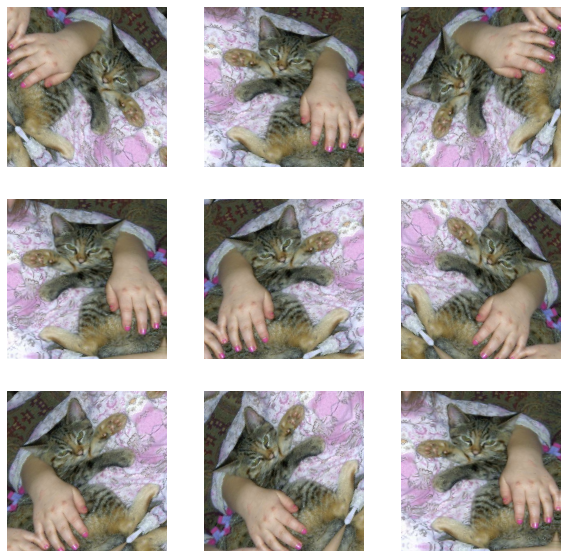

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

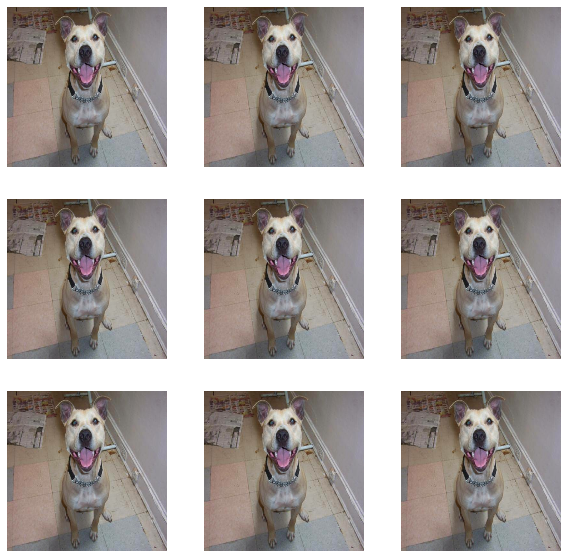

In [ ]:
### Mini-exercise

# Explore a little bit the effect of data augmentation on the data.
# Check the doumentation of the different layers here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/

data_augmentation_exercise = tf.keras.Sequential([
     #technique 1
     #technique 2
     #technique 3                                             
])


for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation_exercise(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

# PART 2: Transfer Learning: the Principles

## Introduction

**Transfer learning** consists of taking features learned on one problem, and
leveraging them on a new, similar problem. For instance, features from a model that has
learned to identify animals in general may be useful to kick-start a model meant to identify birds only.

Transfer learning can be especially useful for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a  new dataset.
4. Train the new layers on your dataset.

A last, optional step, is **fine-tuning**, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

## The typical transfer-learning workflow

This leads us to how a typical transfer learning workflow can be implemented in Keras:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting `trainable = False`.
3. Create a new model on top of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.

Note that an alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers
 from the base model. This is called **feature extraction**.
3. Use that output as input data for a new, smaller model.

A key advantage of that second workflow is that you only run the base model once on
 your data, rather than once per epoch of training. So it's a lot faster & cheaper. You can also use the features extracted for a completely different machine learning model or even task. Personally, I have had great success extracting features with neural nets and inputing them into an XGBoost model for example. It can be very practical for multimodal machine learning.

However, an issue with that second workflow is that it doesn't allow you to dynamically
modify the input data of your new model during training, which is required when doing
data augmentation, for instance. Transfer learning is typically used for tasks when
your new dataset has too little data to train a full-scale model from scratch, and in
such scenarios data augmentation is very important. So in what follows, we will focus
 on the first workflow.

Here's what the first workflow looks like in Keras:

First, instantiate a base model with pre-trained weights.

```python
base_model = keras.applications.<MODELNAME>(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(<height>, <width>, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```

Then, freeze the base model.

```python
base_model.trainable = False
```

Create a new model on top.

```python
inputs = keras.Input(shape=(<height>, <width>, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
# You can change the value to any number of your choice, depending on how many classes you have.
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

Train the model on new data.

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True), #or loss of your choice
              metrics=[keras.metrics.BinaryAccuracy()]) #or metric of your choice
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google, which runs very fast as it was built for running on mobile devices. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit`, `goldfish`, or `forklift`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

Keras conveniently proposes to load many state-of-the-art and widely used models, including ResNet, EfficientNet, Inception,...
Check here the full list: https://www.tensorflow.org/api_docs/python/tf/keras/applications

When you use a pretrained model, be careful to preprocess the data the way they expect it. In particular, check:
- if you need to standardize/normalize differently (in general we standardize using the ImageNet means and stds)
- if you need to reshape the picture (typically many models use the 224x224 size, but others can expect larger, like Xception with 299x299)
- in short, check the `tf` documentation of the model you want to use.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# PART 3: Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, look at the following cells or see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

### Trainable layers

#### Freezing layers: understanding the `trainable` attribute

Layers & models have three weight attributes:

- `weights` is the list of all weights variables of the layer.
- `trainable_weights` is the list of those that are meant to be updated (via gradient
 descent) to minimize the loss during training.
- `non_trainable_weights` is the list of those that aren't meant to be trained.
 Typically they are updated by the model during the forward pass.

**Example: the `Dense` layer has 2 trainable weights (kernel & bias)**

In [ ]:
layer = tf.keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


In general, all weights are trainable weights. The only built-in layer that has
non-trainable weights is the `BatchNormalization` layer. It uses non-trainable weights
 to keep track of the mean and variance of its inputs during training.
To learn how to use non-trainable weights in your own custom layers, see the
[guide to writing new layers from scratch](https://keras.io/guides/making_new_layers_and_models_via_subclassing/).

**Example: the `BatchNormalization` layer has 2 trainable weights and 2 non-trainable
 weights**

In [ ]:
layer = tf.keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


Layers & models also feature a boolean attribute `trainable`. Its value can be changed.
Setting `layer.trainable` to `False` moves all the layer's weights from trainable to
non-trainable.  This is called "freezing" the layer: the state of a frozen layer won't
be updated during training (either when training with `fit()` or when training with
 any custom loop that relies on `trainable_weights` to apply gradient updates).

**Example: setting `trainable` to `False`**

In [ ]:
layer = tf.keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


When a trainable weight becomes non-trainable, its value is no longer updated during training.

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 43ms/step - loss: 0.7033 - accuracy: 0.5371


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.70
initial accuracy: 0.54


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 7s 66ms/step - loss: 0.6745 - accuracy: 0.5830 - val_loss: 0.4740 - val_accuracy: 0.7450
Epoch 2/10
63/63 [==============================] - 4s 62ms/step - loss: 0.4984 - accuracy: 0.7265 - val_loss: 0.3456 - val_accuracy: 0.8564
Epoch 3/10
63/63 [==============================] - 4s 62ms/step - loss: 0.3992 - accuracy: 0.8145 - val_loss: 0.2674 - val_accuracy: 0.8998
Epoch 4/10
63/63 [==============================] - 4s 63ms/step - loss: 0.3305 - accuracy: 0.8530 - val_loss: 0.2215 - val_accuracy: 0.9344
Epoch 5/10
63/63 [==============================] - 4s 62ms/step - loss: 0.3051 - accuracy: 0.8610 - val_loss: 0.1899 - val_accuracy: 0.9443
Epoch 6/10
63/63 [==============================] - 4s 62ms/step - loss: 0.2718 - accuracy: 0.8820 - val_loss: 0.1669 - val_accuracy: 0.9542
Epoch 7/10
63/63 [==============================] - 4s 62ms/step - loss: 0.2535 - accuracy: 0.8900 - val_loss: 0.1491 - val_accuracy: 0.9616
Epoch 8/10
63

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

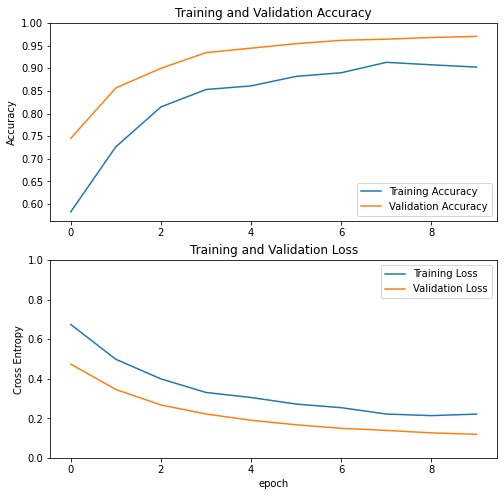

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

# PART 4: Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 10s 84ms/step - loss: 0.1658 - accuracy: 0.9255 - val_loss: 0.0481 - val_accuracy: 0.9876
Epoch 11/20
63/63 [==============================] - 5s 72ms/step - loss: 0.1143 - accuracy: 0.9530 - val_loss: 0.0524 - val_accuracy: 0.9765
Epoch 12/20
63/63 [==============================] - 5s 71ms/step - loss: 0.1211 - accuracy: 0.9505 - val_loss: 0.0429 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 5s 71ms/step - loss: 0.1109 - accuracy: 0.9525 - val_loss: 0.0439 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 5s 70ms/step - loss: 0.0907 - accuracy: 0.9650 - val_loss: 0.0417 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 5s 71ms/step - loss: 0.0920 - accuracy: 0.9615 - val_loss: 0.0404 - val_accuracy: 0.9790
Epoch 16/20
63/63 [==============================] - 5s 71ms/step - loss: 0.0772 - accuracy: 0.9630 - val_loss: 0.0313 - val_accuracy: 0.9864
Epoch

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

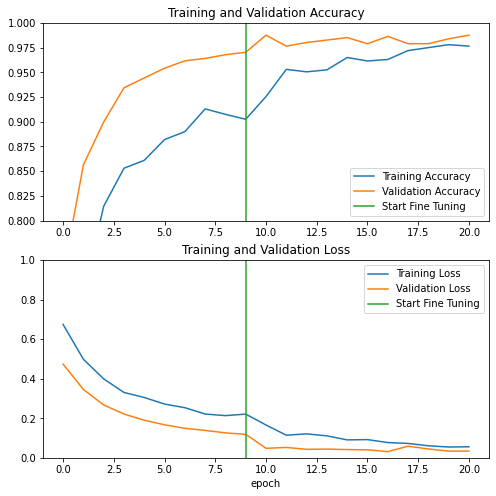

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using the test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 41ms/step - loss: 0.0626 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0]
Labels:
 [0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0]


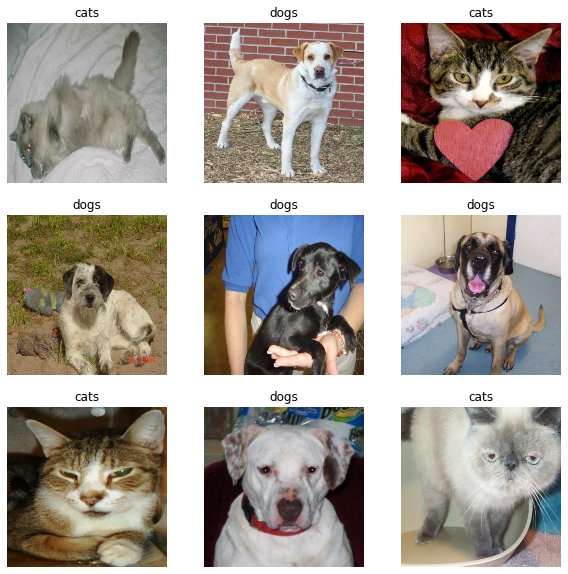

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

It can also be interesting to visualize the mistakes made by the model. It can provide useful information for debugging and improving performance.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


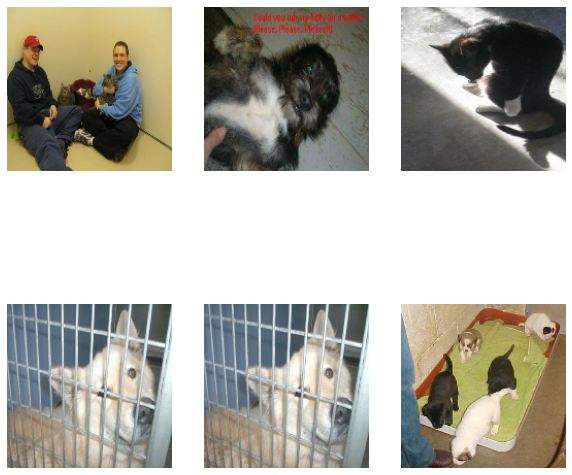

In [ ]:
mistakes = 0
im_mistakes = np.zeros((6, 160, 160, 3))
while mistakes < 6:
  image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch).flatten()

  # Apply a sigmoid since our model returns logits
  predictions = tf.nn.sigmoid(predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)

  mis = tf.where(predictions != label_batch)
  for m in mis: 
      im_mistakes[mistakes] = image_batch[m]
      mistakes+=1
      if mistakes == 6:
        break

plt.figure(figsize=(10, 10))
for i in range(6):
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(im_mistakes[i].astype("uint8"))
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.


# Exercise: Implement the Transfer Learning Workflow on the CIFAR10 dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras

We will work with the __CIFAR10__ dataset that consists of 60,000 32x32x3 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

## Obtain dataset

CIFAR10 is a very famous benchmark dataset and is readily available in the `tensorflow_datasets` library, which is a library that contains many datasets ready to be used with Keras.

In [ ]:
import tensorflow_datasets as tfds

ds_name = "cifar10"

# Get the dataset (extract)
# We will split the trianing dataset to get a validation set
(train_dataset, validation_dataset), info = tfds.load(ds_name,
                    split=["train[:80%]", "train[80%:]"],
                    batch_size = 32,
                    as_supervised=True,
                    with_info = True
                    )

test_dataset, info_test = tfds.load(ds_name,
                    split="test",
                    batch_size = 32,
                    as_supervised=True,
                    with_info = True
                    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete9HMNLN/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete9HMNLN/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


## Preprocessing

Now that we have obtained the data, let's do the preprocessing.




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


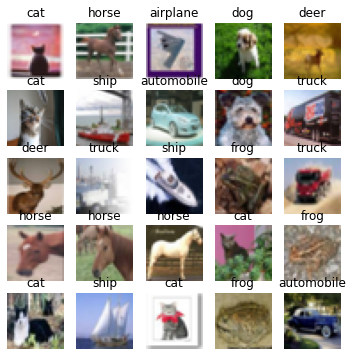

In [ ]:
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

plt.figure(figsize=(6, 6))
for images, labels in train_dataset.take(2):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Data Augmentation
 We will make the data augmentation a layer of our model.

In [ ]:
# Create a data augmentation layer of your choice.
# For example, flip the images horizontally and
# rotates them randomly

data_augmentation = tf.keras.Sequential([
  #technique 1: TODO 1 line
  #technique 2: TODO 1 line
])

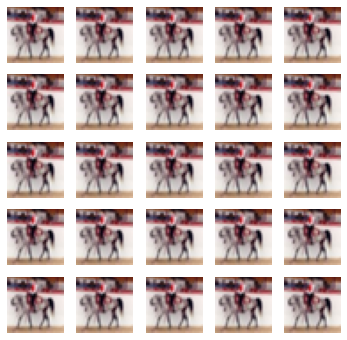

In [ ]:
# Showcase the results 
# Your output should resemble what you see now (most likely with a different bird)

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(6, 6))
  first_image = image[0]
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Transfer Learning

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [ ]:
# To work properly, the pretrained network expect an image of about the same size it was trained on. 
# CIFAR10 is of shape 32x32x3, while ImageNet is generally reshaped as 224x224x3.
# Play a little bit with the SIZE parameter of the resizing. 
# Maybe 32 won't work that well, in that case try another value ;)

SIZE = 32

base_model = keras.applications.<MODEL_NAME>( #TODO Put the model name
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(SIZE, SIZE, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
#TODO 1 line

# Create new model on top
inputs = keras.Input(shape=#TODO
                     )
#This layer resizes the data.
resize_layer = keras.layers.Resizing(SIZE, SIZE)
x = resize_layer(inputs)

# Apply random data augmentation to x
# TODO 1 line

# Pre-trained model weights often require that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
# Rescale the data or use the preprocess_input function
scale_layer = #TODO
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)

#We apply the Pooling layer to obtain a 1 dimensional vector
x = #TODO

# Add dropout if you want
# TODO: Regularize with dropout, 1 line

#Final dense layer of the network. 
# Be careful to the activation function and the number of neurons.
outputs = #TODO

model = keras.Model(inputs, outputs)

model.summary()

SyntaxError: ignored

In [ ]:
model.compile(
    optimizer=#TODO
    loss=#TODO: be careful choosing the right loss function can be tricky, hint look into SparseCategoricalCrossentropy
    metrics="accuracy",
)

epochs = 20
model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)